In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # use 2, 3, 4 or 5

In [2]:
import pandas as pd
import os
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytesseract
import evaluate
from pathlib import Path
sns.set_theme(style="whitegrid")
import datetime
from Levenshtein import ratio

import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(Path(module_path).joinpath("src").as_posix())

from custom_model import CustomTrOCR

# Load Model

In [3]:
# Take object of CustomTrOCR class
cm = CustomTrOCR()

# Enlist current models available in models dir
cm.list_current_models()

../models/Custom_Split_64b_10e_ep5
../models/Custom_Split_64b_10e_ep3
../models/Custom_Split_64b_10e_ep6
../models/Custom_Split_64b_10e_ep8
../models/trocr_base_printed
../models/Custom_Split_64b_10e_ep4
../models/Custom_Split_32b_5e_50subsample_ep0
../models/Custom_Split_32b_5e_50subsample_ep4
../models/Custom_Split_64b_10e_ep9
../models/Custom_Split_32b_5e_50subsample_ep2
../models/Custom_Split_64b_10e_ep0
../models/Custom_Split_32b_5e_50subsample_ep3
../models/trocr_base_handwritten
../models/Custom_Split_64b_10e_ep1
../models/Custom_Split_64b_10e_ep2
../models/trocr_base_str
../models/Custom_Split_64b_10e_ep7
../models/trocr_base_stage1
../models/Custom_Split_32b_5e_50subsample_ep1


In [4]:
# Load best model 
PATH_TO_BEST_MODEL = "../models/Custom_Split_64b_10e_ep9"

# Load Model again (ved and processor)
cm.load_model(PATH_TO_BEST_MODEL)

# Inference / Prediction on Test Set and Evaluation
- The `predict_all()` function takes the test set and predicts the text, given the image path.  
- The `evaluate_test_set()` function expects a dataframe with the label and predictions and computes CER and / or the Levensthein distance / edit distance.

- If `predict_all()` is already computed, just load the dataframe from the corresponding directory, since predicting all can be expensive.

In [5]:
def predict_all(df: pd.DataFrame,
                cm: CustomTrOCR,
                save_dir: str = "../data/predictions/test_df_evaluated_all.json") -> pd.DataFrame:
    """
    Function that takes the test dataframe and predicts the text and saves the df to save_dir
    
    :param df Test Set (Hold Out Set)
    :param save_dir Saving directory
    :param cm Model to take
    :return df DataFrame with prediction column
    """
    
    assert save_dir != "../data/predictions/test_df_evaluated_all.json", print("Please choose other save_dir!")
    
    # Get the image paths from the test data
    image_paths = df['line_img_path'].tolist()

    # Get the true labels from the test data
    labels = df['text'].tolist()

    # Get the predictions from the model
    predictions = cm.predict_batch(image_paths)

    # Create a dataframe with the image paths, labels and predictions
    df = pd.DataFrame({'line_img_path':image_paths, 'labels': labels, 'predictions': predictions})

    # Save df
    df.to_json(save_dir)
    print(f"Saved prediction of test dataframe in: {save_dir}")
    
    return df



def evaluate_test_set(df: pd.DataFrame,
                      save_dir: str = "../data/predictions/test_df_evaluated_all_w_metrices_XXX.json",
                      compute_cer: bool = True,
                      compute_edit_distance: bool = True) -> pd.DataFrame:
    """
    Applies CER and/or Levensthein Distance (Edit distance) on test set with prediction.
    Saves df with the metric scores for each row to save_dir
    
    :param df DataFrame with labels and predictions column to compare
    :param save_dir Saving Directory
    :param compute_cer Bool whether to compute CER or not
    :param computer_edit_distance Bool whether to compute Levensthein distance
    :return Returns df with the metrics as columns
    """
    
    assert "predictions" in df.columns, print("Prediction column missing!")
    
    # Compute cer between labels and predictions
    if compute_cer:
        cer_metric = evaluate.load("cer")
        df["cer"] = df.apply(lambda x: cer_metric.compute(predictions=[x["predictions"]],
                                                          references=[x["labels"]]), axis=1)
        # Print average and std of CER
        cer_mean = np.mean(df["cer"])
        cer_std = np.std(df["cer"])
        print(f"Average CER: {cer_mean:.4f}")
        print(f"Standard Deviation CER: {cer_std:.4f}\n")
        
    # Analog for Levensthein Distance
    if compute_edit_distance:
        df["edit_distance"] = df.apply(lambda x: ratio(x["predictions"], x["labels"]), axis=1)
        
        # Print average and std of CER
        ed_mean = np.mean(df["edit_distance"])
        ed_std = np.std(df["edit_distance"])
        print(f"Average Edit Distance: {ed_mean:.4f}")
        print(f"Standard Deviation Edit Distance: {ed_std:.4f}\n")
        
    df.to_json(save_dir)
    print(f"Saved prediction with metrics dataframe in: {save_dir}")
    
    return df



## Call functions

In [13]:
# Load test data with prediction (yielded from predict_all() function)
#test_df_w_prediction = pd.read_json("../data/predictions/test_df_evaluated_all.json")

# Take sample for testing?
#test_df_w_prediction = test_df_w_prediction.sample(5)

# Print information
#print(f"Shape of test_df_w_prediction: {test_df_w_prediction.shape}")
#test_df_w_prediction.head(5)

In [14]:
# Compute CER and Levensthein of test df with already computed predictions
#test_df_with_metrices = evaluate_test_set(df = test_df_w_prediction,
#                                          save_dir = "../data/predictions/test_df_evaluated_all_w_metrices_XXX.json",
#                                          compute_cer = True,
#                                          compute_edit_distance = True)

# Or Load if already computed:
test_df_with_metrices = pd.read_json("../data/predictions/test_df_evaluated_all_w_metrices.json")
test_df_with_metrices.head(5)

,line_img_path,labels,predictions,cer,edit_distance
0,../data/raw/Kotlin/horizontalsystems~unstoppab...,private val feeChangeHeight: Long = if (te...,private val freeChangeHeight: Long = if (t...,0.135593,0.92562
1,../data/raw/CoffeeScript/EtienneLem~skeleton/e...,if stats.isDirectory(),if stats.isDirectory(),0.000000,1.00000
2,../data/raw/CoffeeScript/EtienneLem~skeleton/e...,# Go through the loop again if it is a dir...,# Go through the loop again if it is a dir...,0.000000,1.00000
3,../data/raw/CoffeeScript/EtienneLem~skeleton/e...,stats = fs.lstatSync(path),stats = fs.lstatSync(path),0.000000,1.00000
4,../data/raw/CoffeeScript/EtienneLem~skeleton/e...,"path = ""#{dir}/#{file}""","path = ""#{dir}/#{file}""",0.000000,1.00000


In [15]:
# Analyse bad objects
test_df_with_metrices[test_df_with_metrices.cer > 10].head(5)

,line_img_path,labels,predictions,cer,edit_distance
9143,../data/raw/Scala/findify~s3mock/src~main~scal...,},</ → ************: },19.0,0.450000
9148,../data/raw/Scala/findify~s3mock/src~main~scal...,),( div class: (,14.0,0.424242
9153,../data/raw/Scala/findify~s3mock/src~main~scal...,),( div class: (,14.0,0.424242
9159,../data/raw/Scala/findify~s3mock/src~main~scal...,),( ) -> (pattern.includes(,24.0,0.244898
9174,../data/raw/Scala/findify~s3mock/src~main~scal...,),( div class: (,14.0,0.424242


In [16]:
test_df_with_metrices.describe().applymap('{:.4f}'.format).transpose()

,count,mean,std,min,25%,50%,75%,max
cer,44277.0000,0.2008,0.8132,0.0000,0.0000,0.0000,0.2000,102.0000
edit_distance,44277.0000,0.9194,0.1383,0.0000,0.8916,1.0000,1.0000,1.0000


## Compare with and without noise characters

In [20]:
# Define Noise characters, i.e. objects containing atleast one of these are flagged
NOISE_CHARACTERS: list = ["|", "→"]

def is_noise_characters(x: str) -> bool:
    """
    Checks whether the input string has a character that is in the NOISE_CHARACTERS list
    :param x Input string to check
    :return Bool True if String has noise character, else False
    """
    for char in NOISE_CHARACTERS:
        if char in x:
            return True
        
    return False


In [ ]:
# Append flag to df
test_df_with_metrices_flag = test_df_with_metrices.copy()
test_df_with_metrices_flag["flag_noise"] = test_df_with_metrices["predictions"].apply(lambda x: is_noise_characters(x))

# Analysis of CER without objects that contain noise chars
test_df_with_metrices_flag[test_df_with_metrices_flag.flag_noise == False].describe().applymap('{:.4f}'.format).transpose()

_______
# Compare other base models from HuggingFace

In [18]:
# Read test df
test_df = pd.read_json("../data/extracted/training/Custom_Split_64b_10e/test_df")
test_df.head(5)

,line_img_path,font,theme,language,line_number,text,text_size,contains_chinese
line287530,../data/raw/Kotlin/horizontalsystems~unstoppab...,Crystal,(Actual) Obsidian,Kotlin,52.0,private val feeChangeHeight: Long = if (te...,59,False
line153994,../data/raw/CoffeeScript/EtienneLem~skeleton/e...,Crystal,(Actual) Obsidian,CoffeeScript,11.0,if stats.isDirectory(),22,False
line153993,../data/raw/CoffeeScript/EtienneLem~skeleton/e...,Crystal,(Actual) Obsidian,CoffeeScript,10.0,# Go through the loop again if it is a dir...,48,False
line153991,../data/raw/CoffeeScript/EtienneLem~skeleton/e...,Crystal,(Actual) Obsidian,CoffeeScript,8.0,stats = fs.lstatSync(path),26,False
line153990,../data/raw/CoffeeScript/EtienneLem~skeleton/e...,Crystal,(Actual) Obsidian,CoffeeScript,7.0,"path = ""#{dir}/#{file}""",23,False


In [19]:
# Take object of CustomTrOCR class
cm_base_printed = CustomTrOCR()
cm_base_printed.load_model("../models/trocr_base_printed")
# Ignore if its already downloaded
#cm_base_printed.dump_model(dir_path = "../models/trocr_base_printed")

#df_evaluated_base = predict_all(df=test_df, 
#                                cm=cm_base_stage,
#                                save_dir="../data/predictions/test_df_printed_evaluated.json")

## Analog for handwritten, str, base stage1
Load either from huggingface (or if already downloaded) from local dir

In [20]:
#############################################################
#### Skip if already computed; Load from predictions dir ####
#############################################################

#cm_base_handwritten = CustomTrOCR()
#cm_base_handwritten.load_model("../models/trocr_base_handwritten")
#df_evaluated_handwritten = predict_all(df=test_df, 
#                                cm=cm_base_handwritten,
#                                save_dir="../data/predictions/test_df_handwritten_evaluated.json")
#cm_base_str = CustomTrOCR()
#cm_base_str.load_model("../models/trocr_base_str")
#df_evaluated_str = predict_all(df=test_df, 
#                                cm=cm_base_str,
#                                save_dir="../data/predictions/test_df_str_evaluated.json")
#cm_base_base = CustomTrOCR()
#cm_base_base.load_model("../models/trocr_base_stage1")
#df_evaluated_str = predict_all(df=test_df, 
#                                cm=cm_base_base,
#                                save_dir="../data/predictions/test_df_base_evaluated.json")

_______
## Analysis of Base Models
- df_evaluated_printed
- df_evaluated_handwritten
- df_evaluated_str
- df_evaluated_base


In [21]:
#############################################################
#### Skip if already computed; Load from predictions dir ####
#############################################################

#test_df_printed_with_metrices = evaluate_test_set(df = df_evaluated_printed,
#                                          save_dir = "../data/predictions/test_df_printed_evaluated_cer.json",
#                                          compute_cer = True,
#                                          compute_edit_distance = False)

#test_df_handwritten_with_metrices = evaluate_test_set(df = df_evaluated_handwritten,
#                                          save_dir = "../data/predictions/test_df_handwritten_evaluated_cer.json",
#                                          compute_cer = True,
#                                          compute_edit_distance = False)

#test_df_str_with_metrices = evaluate_test_set(df = df_evaluated_str,
#                                          save_dir = "../data/predictions/test_df_str_evaluated_cer.json",
#                                          compute_cer = True,
#                                          compute_edit_distance = False)

#test_df_base_with_metrices = evaluate_test_set(df = df_evaluated_base,
#                                          save_dir = "../data/predictions/test_df_base_evaluated_cer.json",
#                                          compute_cer = True,
#                                          compute_edit_distance = False)

________
# CER Analysis of base models
In this section we analyse the CER value of the base models and take the results for our elaboration.

____
## Base Model: Printed

In [22]:
test_df_printed_with_metrices = pd.read_json("../data/predictions/test_df_printed_evaluated_cer.json")
test_df_printed_with_metrices.describe().applymap('{:.4f}'.format).transpose()

,count,mean,std,min,25%,50%,75%,max
cer,44277.0000,0.9483,0.8573,0.0000,0.7778,0.8772,1.0000,37.0000


In [23]:
test_df_printed_with_metrices_flagged = test_df_printed_with_metrices.copy()
test_df_printed_with_metrices_flagged["flag_noise"] = test_df_printed_with_metrices_flagged["predictions"].apply(lambda x: is_noise_characters(x))

# Analysis of CER without objects that contain noise chars
test_df_printed_with_metrices_flagged[test_df_printed_with_metrices_flagged.flag_noise == False].describe().applymap('{:.4f}'.format).transpose()

,count,mean,std,min,25%,50%,75%,max
cer,43797.0000,0.9486,0.8617,0.0000,0.7750,0.8762,1.0000,37.0000


____
## Base Model: Handwritten

In [24]:
test_df_handwritten_with_metrices = pd.read_json("../data/predictions/test_df_handwritten_evaluated_cer.json")
test_df_handwritten_with_metrices.describe().applymap('{:.4f}'.format).transpose()

,count,mean,std,min,25%,50%,75%,max
cer,44277.0000,1.0931,1.2170,0.0000,0.6418,0.8485,1.0741,101.0000


In [25]:
test_df_handwritten_with_metrices_flagged = test_df_handwritten_with_metrices.copy()
test_df_handwritten_with_metrices_flagged["flag_noise"] = test_df_handwritten_with_metrices_flagged["predictions"].apply(lambda x: is_noise_characters(x))

# Analysis of CER without objects that contain noise chars
test_df_handwritten_with_metrices_flagged[test_df_handwritten_with_metrices_flagged.flag_noise == False].describe().applymap('{:.4f}'.format).transpose()

,count,mean,std,min,25%,50%,75%,max
cer,44277.0000,1.0931,1.2170,0.0000,0.6418,0.8485,1.0741,101.0000


_____
## Base Model: STR

In [26]:
test_df_str_with_metrices = pd.read_json("../data/predictions/test_df_str_evaluated_cer.json")
test_df_str_with_metrices.describe().applymap('{:.4f}'.format).transpose()

,count,mean,std,min,25%,50%,75%,max
cer,44277.0000,1.0150,0.6953,0.0000,0.8125,0.9630,1.0000,12.0000


In [27]:
test_df_str_with_metrices_flagged = test_df_str_with_metrices.copy()
test_df_str_with_metrices_flagged["flag_noise"] = test_df_str_with_metrices_flagged["predictions"].apply(lambda x: is_noise_characters(x))

# Analysis of CER without objects that contain noise chars
test_df_str_with_metrices_flagged[test_df_str_with_metrices_flagged.flag_noise == False].describe().applymap('{:.4f}'.format).transpose()

,count,mean,std,min,25%,50%,75%,max
cer,44277.0000,1.0150,0.6953,0.0000,0.8125,0.9630,1.0000,12.0000


____
## Base Model: Base Stage1

In [28]:
test_df_base_with_metrices = pd.read_json("../data/predictions/test_df_base_evaluated_cer.json")
test_df_base_with_metrices.describe().applymap('{:.4f}'.format).transpose()

,count,mean,std,min,25%,50%,75%,max
cer,44277.0000,0.7127,2.2413,0.0000,0.1000,0.2759,0.7213,84.0000


In [29]:
test_df_base_with_metrices_flagged = test_df_base_with_metrices.copy()
test_df_base_with_metrices_flagged["flag_noise"] = test_df_base_with_metrices_flagged["predictions"].apply(lambda x: is_noise_characters(x))

# Analysis of CER without objects that contain noise chars
test_df_base_with_metrices_flagged[test_df_base_with_metrices_flagged.flag_noise == False].describe().applymap('{:.4f}'.format).transpose()

,count,mean,std,min,25%,50%,75%,max
cer,42307.0000,0.7197,2.2872,0.0000,0.0952,0.2667,0.7264,84.0000


___
# Comparison with Tesseract

In [30]:
# Read Hold Out Set (Test DF)
#test_df = pd.read_json("../data/extracted/training/Custom_Split_64b_10e/test_df")

# Filter
#df_evaluated_tesseract = test_df.copy()
#df_evaluated_tesseract = df_evaluated_tesseract[["line_img_path", "text"]]
#df_evaluated_tesseract.head(2)

In [31]:
def tesseract_ocr(code_image):
    return pytesseract.image_to_string(code_image)

In [32]:
# Inference
#df_evaluated_tesseract["predictions"] = df_evaluated_tesseract["line_img_path"].apply(lambda x: tesseract_ocr(x))
#df_evaluated_tesseract.to_json("../data/predictions/test_df_tesseract_evaluated.json")

#df_evaluated_tesseract.head(3)

In [36]:
# CER Evaluation
#cer_metric = evaluate.load("cer")
#df_evaluated_tesseract["cer"] = df_evaluated_tesseract.apply(lambda x: cer_metric.compute(predictions=[x["predictions"]],
#                                                          references=[x["text"]]), axis=1)
# Save df
#df_evaluated_tesseract.to_json("../data/predictions/test_df_tesseract_evaluated_cer.json")

In [ ]:
#img = cv2.imread(df_evaluated_tesseract.iloc[4,0])
#plt.grid(None)
#plt.imshow(img)

In [34]:
# Read if already trained
test_df_tesseract_with_metrices = pd.read_json("../data/predictions/test_df_tesseract_evaluated_cer.json")
test_df_tesseract_with_metrices.describe().applymap('{:.4f}'.format).transpose()

,count,mean,std,min,25%,50%,75%,max
cer,44277.0000,0.4434,0.4625,0.0000,0.0000,0.1765,0.9375,14.0000


In [35]:
test_df_tesseract_with_metrices_flagged = test_df_tesseract_with_metrices.copy()
test_df_tesseract_with_metrices_flagged["flag_noise"] = test_df_tesseract_with_metrices_flagged["predictions"].apply(lambda x: is_noise_characters(x))

# Analysis of CER without objects that contain noise chars
test_df_tesseract_with_metrices_flagged[test_df_tesseract_with_metrices_flagged.flag_noise == False].describe().applymap('{:.4f}'.format).transpose()

,count,mean,std,min,25%,50%,75%,max
cer,42688.0000,0.4455,0.4645,0.0000,0.0000,0.1750,0.9474,14.0000


## Binarized Test Image Test
Test custom fined model on binarized images 

In [6]:
# Replace with path to bw image
test_df = pd.read_json("../data/extracted/training/Custom_Split_64b_10e/test_df")
test_df.head(2)

,line_img_path,font,theme,language,line_number,text,text_size,contains_chinese
line287530,../data/raw/Kotlin/horizontalsystems~unstoppab...,Crystal,(Actual) Obsidian,Kotlin,52.0,private val feeChangeHeight: Long = if (te...,59,False
line153994,../data/raw/CoffeeScript/EtienneLem~skeleton/e...,Crystal,(Actual) Obsidian,CoffeeScript,11.0,if stats.isDirectory(),22,False


In [7]:
test_df.iloc[0,0]

'../data/raw/Kotlin/horizontalsystems~unstoppable-wallet-android/app~src~main~java~io~horizontalsystems~bankwallet~core~adapters~zcash~ZcashAdapter.kt/line_images_cw/line52.0.png'

In [8]:
# Convert to _bw image path
test_df["line_img_path"] = test_df["line_img_path"].str.replace(".png", "_bw.png")
test_df.iloc[0,0]

/tmp/ipykernel_55460/3604187897.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df["line_img_path"] = test_df["line_img_path"].str.replace(".png", "_bw.png")


'../data/raw/Kotlin/horizontalsystems~unstoppable-wallet-android/app~src~main~java~io~horizontalsystems~bankwallet~core~adapters~zcash~ZcashAdapter.kt/line_images_cw/line52.0_bw.png'

In [9]:
test_df_evaluated = predict_all(df=test_df, 
                                cm=cm, 
                                save_dir="../data/predictions/test_df_binarized_evaluated.json")

/home/negrini/Desktop/trocr/trocr_env39/lib/python3.9/site-packages/transformers/generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Saved prediction of test dataframe in: ../data/predictions/test_df_binarized_evaluated.json


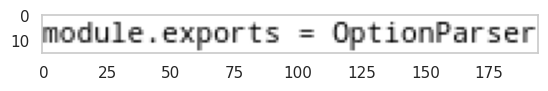

In [23]:
img = cv2.imread(test_df_evaluated.iloc[12,0])
plt.grid(None)
plt.imshow(img)

In [10]:
test_df_evaluated_cer = evaluate_test_set(df = test_df_evaluated,
                                          save_dir = "../data/predictions/test_df_binarized_evaluated_cer.json",
                                          compute_cer = True,
                                          compute_edit_distance = False)

Average CER: 0.1882
Standard Deviation CER: 0.8172

Saved prediction with metrics dataframe in: ../data/predictions/test_df_binarized_evaluated_cer.json


In [11]:
test_df_evaluated_leven = evaluate_test_set(df = test_df_evaluated,
                                          save_dir = "../data/predictions/test_df_binarized_evaluated_leven.json",
                                          compute_cer = False,
                                          compute_edit_distance = True)

Average Edit Distance: 0.9069
Standard Deviation Edit Distance: 0.1562

Saved prediction with metrics dataframe in: ../data/predictions/test_df_binarized_evaluated_leven.json


In [18]:
test_df_evaluated_cer.describe().applymap('{:.4f}'.format).transpose()

,count,mean,std,min,25%,50%,75%,max
cer,44277.0000,0.1882,0.8172,0.0000,0.0000,0.0000,0.2000,38.0000
edit_distance,44277.0000,0.9069,0.1562,0.0000,0.8732,0.9897,1.0000,1.0000


In [21]:
test_df_evaluated_cer_flagged = test_df_evaluated_cer.copy()
test_df_evaluated_cer_flagged["flag_noise"] = test_df_evaluated_cer_flagged["predictions"].apply(lambda x: is_noise_characters(x))

# Analysis of CER without objects that contain noise chars
test_df_evaluated_cer_flagged[test_df_evaluated_cer_flagged.flag_noise == False].describe().applymap('{:.4f}'.format).transpose()

,count,mean,std,min,25%,50%,75%,max
cer,38096.0000,0.1436,0.8209,0.0000,0.0000,0.0000,0.0833,38.0000
edit_distance,38096.0000,0.9223,0.1504,0.0000,0.9155,1.0000,1.0000,1.0000
